# Análisis de redes

## Instalar e importar librerías

In [1]:
!apt install libgraphviz-dev
!pip install pygraphviz
from IPython.display import clear_output
clear_output()

In [2]:
import os
import pandas as pd
import plotly.graph_objects as go
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import itertools
import numpy as np
from tqdm import tqdm
from collections import defaultdict

In [3]:
# This cell set up all the required styling

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.font_manager import fontManager, FontProperties
from matplotlib.patches import FancyBboxPatch

MAIN_COLOR = "#37539C"

BLUE_PALETTE = [
    "#869CD4",
    "#4969BE",
    "#4062BB",
    "#354F95",
    "#2D4175",
    "#27355A"
]

COLOR_PALETTE = [
    MAIN_COLOR,
    "#59C3C3",
    "#F45B69",
    "#52489C",
    "#9FB7B9",
    "#EBEBEB",
    "#4062BB",
    "#46B1C9",
    "#84C0C6",
    "#BCC1BA",
    "#F2E2D2"
]

def install_open_sans():
  """Install Open Sans fonts from directory, and set them as the default
  """
  fonts_dir = "/content/drive/Shareddrives/Estudio Ecosistema CTCI/PT5_Informe Final/open_sans_fonts"
  for font_path in os.listdir(fonts_dir):
    full_path = os.path.join(fonts_dir, font_path)
    fontManager.addfont(full_path)

def set_properties(font_family, main_color, color_palette):
  # Set font
  mpl.rc('font', family=font_family)
  # Set font weight to bold in everything
  mpl.rcParams["font.weight"] = "bold"
  mpl.rcParams["font.weight"] = "bold"
  mpl.rcParams["axes.titleweight"] = "bold"
  mpl.rcParams["axes.labelweight"] = "bold"

  # Set color of text, labels and ticks
  mpl.rcParams['text.color'] = main_color
  mpl.rcParams['axes.labelcolor'] = main_color
  mpl.rcParams['xtick.color'] = main_color
  mpl.rcParams['ytick.color'] = main_color

  # Set default colormap
  mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=color_palette)

  # Set thant only left and bottom plot spines should be visible
  # (instead of a whole square around the plot)
  mpl.rcParams['axes.spines.left'] = True
  mpl.rcParams['axes.spines.bottom'] = True
  mpl.rcParams['axes.spines.right'] = False
  mpl.rcParams['axes.spines.top'] = False

  # Set horizontal grid
  mpl.rcParams["axes.grid"] = True
  mpl.rcParams["axes.grid.axis"] = "y"
  mpl.rcParams["grid.linestyle"] = "--"

  # Set default linestyle and marker
  mpl.rcParams["lines.linestyle"] = "-"
  mpl.rcParams["lines.marker"] = "o"

  # Set default DPI for image saving (300 is the mininum recommended for printing)
  mpl.rcParams['savefig.dpi'] = 300


install_open_sans()
set_properties("Open Sans", MAIN_COLOR, COLOR_PALETTE)


def round_corners(ax):
  new_patches = []
  old_bottom, old_top = ax.get_ylim()
  for patch in reversed(ax.patches):
      bb = patch.get_bbox()
      if bb.height == 0:
        new_patches.append(patch)
        continue
      color=patch.get_facecolor()
      p_bbox = FancyBboxPatch((bb.xmin, bb.ymin),
                          abs(bb.width), abs(bb.height),
                          boxstyle="round,pad=-0.0040,rounding_size=0.1",
                          ec="none", fc=color,
                          mutation_aspect=4
                          )
      patch.remove()
      new_patches.append(p_bbox)
  for patch in new_patches:
      ax.add_patch(patch)

  # Fix ylim
  ax.set_ylim(old_bottom, old_top)

## Cargar datos

In [4]:
data_dir = "/content/drive/Shareddrives/Estudio Ecosistema CTCI/PT2_Sistematización fuentes de información/Análisis/ANID_CORFO/Resultados/ANID"
df_all = pd.read_excel(os.path.join(data_dir, "data_anid_final.xlsx"))

In [5]:
df_all

,PROGRAMA,CONCURSO,FOLIO,AGNOPOSTULACION,AGNOFALLO,RESPONSABLEPROYECTO,SEXO,ROLINSTITUCION,INSTITUCION1ERNIVEL,RUTINSTITUCION,...,SUBDIRECCION,nombre_normalizado,rut_valido,rut_dv,nombre_canonico,empresa_tipo,empresa_subtipo,provincia,comuna,tipo_institucion_final
0,REGIONAL,II CONCURSO DE FORTALECIMIENTO A LA CONTINUIDA...,R15A10001,2015,2016,EDUARDO GRATACOS,HOMBRE,BENEFICIARIA PRINCIPAL,CENTRO REGIONAL DE INNOVACION HORTOFRUTICOLA ...,SIN INFORMACION,...,SCIA,CENTRO REGIONAL DE INNOVACION HORTOFRUTICOLA D...,False,NaN,CENTRO REGIONAL DE INNOVACION HORTOFRUTICOLA D...,NaN,NaN,NaN,NaN,NaN
1,REGIONAL,II CONCURSO DE FORTALECIMIENTO A LA CONTINUIDA...,R15A10002,2015,2016,LUIS ROJAS ARAYA,HOMBRE,BENEFICIARIA PRINCIPAL,CENTRO DE INVESTIGACION CIENTIFICO TECNOLOGICO...,SIN INFORMACION,...,SCIA,CENTRO DE INVESTIGACION CIENTIFICO TECNOLOGICO...,True,65937660-1,CENTRO DE INVESTIGACION CIENTIFICO TECNOLOGICO...,ORG. SIN FINES DE LUCRO,CORPORACION,ANTOFAGASTA,ANTOFAGASTA,Institución Privada Sin Fines de Lucro
2,PIA,CONCURSO NACIONAL DE ASIGNACION DE TIEMPO DE B...,AUB160003,2016,2016,RUBEN ESCRIBANO VELOSO,HOMBRE,INSTITUCION PATROCINANTE,UNIVERSIDAD DE CONCEPCION,81494400-K,...,SCIA,UNIVERSIDAD DE CONCEPCION,True,81494400-k,UNIVERSIDAD DE CONCEPCION,ORG. SIN FINES DE LUCRO,CORPORACION,CONCEPCIÓN,CONCEPCION,Institución de Educación Superior
3,REGIONAL,II CONCURSO DE FORTALECIMIENTO DE CENTROS REGI...,R16F10008,2016,2016,EDUARDO GRATACOS N.,HOMBRE,BENEFICIARIA PRINCIPAL,CENTRO REGIONAL DE INNOVACION HORTOFRUTICOLA ...,SIN INFORMACION,...,SCIA,CENTRO REGIONAL DE INNOVACION HORTOFRUTICOLA D...,False,NaN,CENTRO REGIONAL DE INNOVACION HORTOFRUTICOLA D...,NaN,NaN,NaN,NaN,NaN
4,REGIONAL,II CONCURSO DE FORTALECIMIENTO DE CENTROS REGI...,R16F10009,2016,2016,BERNARDO BROITMAN ROJAS,HOMBRE,BENEFICIARIA PRINCIPAL,CENTRO DE ESTUDIOS AVANZADOS EN ZONAS ARIDAS (...,SIN INFORMACION,...,SCIA,CENTRO DE ESTUDIOS AVANZADOS EN ZONAS ARIDAS -...,True,65997470-3,CENTRO DE ESTUDIOS AVANZADOS EN ZONAS ARIDAS,ORG. SIN FINES DE LUCRO,OTRA OSFL,ELQUI,LA SERENA,Institución Privada Sin Fines de Lucro
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23703,PCI,PROGRAMAS REGIONALES STIC-AMSUD - MATH-AMSUD -...,AMSUD220044,2022,2023,DENISSE MUÑANTE ARZAPALO,FEMENINO,INSTITUCION DE FRANCIA,ECOLE NATIONALE SUPERIEURE D’INFORMATIQUE POUR...,NaN,...,SREC,ECOLE NATIONALE SUPERIEURE D'INFORMATIQUE POUR...,False,NaN,ECOLE NATIONALE SUPERIEURE D'INFORMATIQUE POUR...,NaN,NaN,NaN,NaN,Internacional
23704,PCI,PROGRAMAS REGIONALES STIC-AMSUD - MATH-AMSUD -...,AMSUD220045,2022,2023,HUGO CARRILLO LINCOPI,MASCULINO,INSTITUCION DE FRANCIA,INRIA PARIS,NaN,...,SREC,INRIA PARIS,False,NaN,INRIA PARIS,NaN,NaN,NaN,NaN,Internacional
23705,PCI,PROGRAMAS REGIONALES STIC-AMSUD - MATH-AMSUD -...,AMSUD220045,2022,2023,HUGO CARRILLO LINCOPI,MASCULINO,INSTITUCION SUDAMERICANA,ESCUELA POLITECNICA NACIONAL,NaN,...,SREC,ESCUELA POLITECNICA NACIONAL,False,NaN,ESCUELA POLITECNICA NACIONAL,NaN,NaN,NaN,NaN,Internacional
23706,PCI,PROGRAMAS REGIONALES STIC-AMSUD - MATH-AMSUD -...,AMSUD220045,2022,2023,HUGO CARRILLO LINCOPI,MASCULINO,INSTITUCION SUDAMERICANA,FUNDACION INRIA CHILE,65058044-3,...,SREC,FUNDACION INRIA CHILE,True,65058044-3,FUNDACION INRIA CHILE,ORG. SIN FINES DE LUCRO,FUNDACION,SANTIAGO,LAS CONDES,Institución Privada Sin Fines de Lucro


Crearemos un dataframe de datos válidos; es decir, donde `tipo_institucion_final` no sea nulo ni "Otra".

In [6]:
df_valid = df_all[(~df_all["tipo_institucion_final"].isnull()) &
                  (df_all["tipo_institucion_final"] != "Otra")]
df_valid

,PROGRAMA,CONCURSO,FOLIO,AGNOPOSTULACION,AGNOFALLO,RESPONSABLEPROYECTO,SEXO,ROLINSTITUCION,INSTITUCION1ERNIVEL,RUTINSTITUCION,...,SUBDIRECCION,nombre_normalizado,rut_valido,rut_dv,nombre_canonico,empresa_tipo,empresa_subtipo,provincia,comuna,tipo_institucion_final
1,REGIONAL,II CONCURSO DE FORTALECIMIENTO A LA CONTINUIDA...,R15A10002,2015,2016,LUIS ROJAS ARAYA,HOMBRE,BENEFICIARIA PRINCIPAL,CENTRO DE INVESTIGACION CIENTIFICO TECNOLOGICO...,SIN INFORMACION,...,SCIA,CENTRO DE INVESTIGACION CIENTIFICO TECNOLOGICO...,True,65937660-1,CENTRO DE INVESTIGACION CIENTIFICO TECNOLOGICO...,ORG. SIN FINES DE LUCRO,CORPORACION,ANTOFAGASTA,ANTOFAGASTA,Institución Privada Sin Fines de Lucro
2,PIA,CONCURSO NACIONAL DE ASIGNACION DE TIEMPO DE B...,AUB160003,2016,2016,RUBEN ESCRIBANO VELOSO,HOMBRE,INSTITUCION PATROCINANTE,UNIVERSIDAD DE CONCEPCION,81494400-K,...,SCIA,UNIVERSIDAD DE CONCEPCION,True,81494400-k,UNIVERSIDAD DE CONCEPCION,ORG. SIN FINES DE LUCRO,CORPORACION,CONCEPCIÓN,CONCEPCION,Institución de Educación Superior
4,REGIONAL,II CONCURSO DE FORTALECIMIENTO DE CENTROS REGI...,R16F10009,2016,2016,BERNARDO BROITMAN ROJAS,HOMBRE,BENEFICIARIA PRINCIPAL,CENTRO DE ESTUDIOS AVANZADOS EN ZONAS ARIDAS (...,SIN INFORMACION,...,SCIA,CENTRO DE ESTUDIOS AVANZADOS EN ZONAS ARIDAS -...,True,65997470-3,CENTRO DE ESTUDIOS AVANZADOS EN ZONAS ARIDAS,ORG. SIN FINES DE LUCRO,OTRA OSFL,ELQUI,LA SERENA,Institución Privada Sin Fines de Lucro
7,REGIONAL,II CONCURSO DE FORTALECIMIENTO DE CENTROS REGI...,R16F10003,2016,2016,CLAUDIO PARRA MONTES,HOMBRE,BENEFICIARIA PRINCIPAL,CENTRO DE INVESTIGACIONES DEL HOMBRE EN EL DES...,SIN INFORMACION,...,SCIA,CENTRO DE INVESTIGACIONES DEL HOMBRE EN EL DES...,True,65412080-3,CENTRO DE INVESTIGACIONES DEL HOMBRE EN EL DES...,ORG. SIN FINES DE LUCRO,OTRA OSFL,IQUIQUE,ARICA,Institución Privada Sin Fines de Lucro
8,REGIONAL,II CONCURSO DE FORTALECIMIENTO DE CENTROS REGI...,R16F10010,2016,2016,ARACELI OLIVARES MIRALLES,MUJER,BENEFICIARIA PRINCIPAL,CENTRO REGIONAL DE ESTUDIOS EN ALIMENTOS SALUD...,SIN INFORMACION,...,SCIA,CENTRO REGIONAL DE ESTUDIOS EN ALIMENTOS SALUD...,True,65072516-6,CENTRO REGIONAL DE ESTUDIOS EN ALIMENTOS SALUD...,ORG. SIN FINES DE LUCRO,CORPORACION,VALPARAÍSO,VALPARAISO,Institución Privada Sin Fines de Lucro
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23703,PCI,PROGRAMAS REGIONALES STIC-AMSUD - MATH-AMSUD -...,AMSUD220044,2022,2023,DENISSE MUÑANTE ARZAPALO,FEMENINO,INSTITUCION DE FRANCIA,ECOLE NATIONALE SUPERIEURE D’INFORMATIQUE POUR...,NaN,...,SREC,ECOLE NATIONALE SUPERIEURE D'INFORMATIQUE POUR...,False,NaN,ECOLE NATIONALE SUPERIEURE D'INFORMATIQUE POUR...,NaN,NaN,NaN,NaN,Internacional
23704,PCI,PROGRAMAS REGIONALES STIC-AMSUD - MATH-AMSUD -...,AMSUD220045,2022,2023,HUGO CARRILLO LINCOPI,MASCULINO,INSTITUCION DE FRANCIA,INRIA PARIS,NaN,...,SREC,INRIA PARIS,False,NaN,INRIA PARIS,NaN,NaN,NaN,NaN,Internacional
23705,PCI,PROGRAMAS REGIONALES STIC-AMSUD - MATH-AMSUD -...,AMSUD220045,2022,2023,HUGO CARRILLO LINCOPI,MASCULINO,INSTITUCION SUDAMERICANA,ESCUELA POLITECNICA NACIONAL,NaN,...,SREC,ESCUELA POLITECNICA NACIONAL,False,NaN,ESCUELA POLITECNICA NACIONAL,NaN,NaN,NaN,NaN,Internacional
23706,PCI,PROGRAMAS REGIONALES STIC-AMSUD - MATH-AMSUD -...,AMSUD220045,2022,2023,HUGO CARRILLO LINCOPI,MASCULINO,INSTITUCION SUDAMERICANA,FUNDACION INRIA CHILE,65058044-3,...,SREC,FUNDACION INRIA CHILE,True,65058044-3,FUNDACION INRIA CHILE,ORG. SIN FINES DE LUCRO,FUNDACION,SANTIAGO,LAS CONDES,Institución Privada Sin Fines de Lucro


## Pequeño análisis

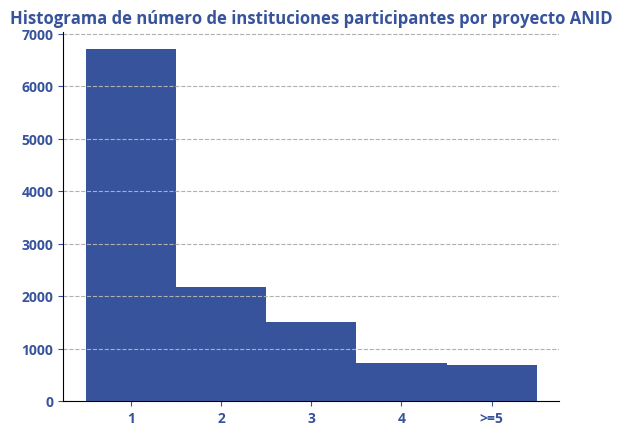

In [7]:
n_relations_by_id = df_valid.groupby("FOLIO").count()["PROGRAMA"]
_ = plt.hist(np.clip(n_relations_by_id, 0, 5), bins=range(1, 7) )
_ = plt.title("Histograma de número de instituciones participantes por proyecto ANID")
_ = plt.xticks(np.arange(1.5, 5.500001, 1), [1, 2, 3, 4, ">=5"])

In [8]:
df_valid["tipo_institucion_final"].value_counts(dropna=False)

Institución de Educación Superior         17166
Internacional                              2248
Empresa                                    1477
Institución Privada Sin Fines de Lucro     1116
Estado                                      974
Name: tipo_institucion_final, dtype: int64

In [9]:
df_valid["ROLINSTITUCION"].value_counts(dropna=False)

INSTITUCION PRINCIPAL                                        7498
INSTITUCION SECUNDARIA                                       3960
ENTIDAD ASOCIADA                                             1853
INSTITUCION ASOCIADA                                         1623
BENEFICIARIA PRINCIPAL                                       1384
INSTITUCION PATROCINANTE                                     1268
INSTITUCION APORTANTE                                         662
INSTITUCION EXTRANJERA                                        615
INSTITUCION BENEFICIARIA                                      523
CENTRO EXTRANJERO PRINCIPAL                                   288
INSTITUCION SUDAMERICANA                                      260
ENTIDAD ASOCIADA / MANDANTE                                   220
CENTRO EXTRANJERO ASOCIADO                                    215
INSTITUCION ALBERGANTE                                        201
INSTITUCION NACIONAL PATROCINANTE                             175
OTRA BENEF

In [10]:
grouped_df = df_valid.groupby("FOLIO").agg({"nombre_canonico": lambda x: x})
grouped_df

,nombre_canonico
FOLIO,
1160001,PONTIFICIA UNIVERSIDAD CATOLICA DE CHILE
1160004,UNIVERSIDAD DE LA SERENA
1160005,"[UNIVERSIDAD DE LA FRONTERA, UNIVERSIDAD DE LA..."
1160013,"[UNIVERSIDAD DE SANTIAGO DE CHILE, UNIVERSIDAD..."
1160015,"[UNIVERSIDAD DE CHILE, INSTITUTO DE DIAGNOSTIC..."
...,...
VIU22P0095,UNIVERSIDAD DE LA FRONTERA
VIU22P0101,UNIVERSIDAD DE LA FRONTERA
VIU22P0103,UNIVERSIDAD DE CONCEPCION


## Grafos

### Grafos simples (consolidados por tipo de institución)

In [11]:
def deg2rad(degrees):
  return np.pi*degrees/180

def generate_pentagon(radius=1, rotation=0):
  angles = np.array([18, 90, 162, 234, 306])+ rotation
  coords = np.array([(radius*np.cos(deg2rad(angle)), radius*np.sin(deg2rad(angle))) for angle in angles])
  return coords

def get_map_names_institutions(df):
  name2inst = {}
  unique_names = df_valid["nombre_canonico"].unique()
  for name in unique_names:
    inst_type = df_valid.loc[df_valid["nombre_canonico"] == name, "tipo_institucion_final"].unique()
    assert len(inst_type) == 1
    name2inst[name] = inst_type[0]
  return name2inst

def count_relations(df,
                    agg_column="tipo_institucion_final",
                    normalize=True):
  grouped_df = df.groupby("FOLIO").agg({agg_column: lambda x: x})
  # Generate weights
  ## Count the number of relations
  counts = defaultdict(lambda: 0)
  for project_id, row in tqdm(grouped_df.iterrows()):
    institutions = row[agg_column]
    if type(institutions) == str:
      continue
    combinations = [sorted(comb) for comb in itertools.combinations(institutions, 2)]
    for (u, v) in combinations:
      counts[(u,v)] += 1

  ## Normalize
  if normalize:
    total = sum(counts.values())
    weights = {key: (value / total) for key, value in counts.items()}
    return weights

  return counts

def count_relations_2(df,
                      map_names_inst,
                      normalize=True,
                      remove_self_loops=True):
  grouped_df = df.groupby("FOLIO").agg({"nombre_canonico": lambda x: x})
  # Generate weights
  ## Count the number of relations
  counts = defaultdict(lambda: 0)
  for project_id, row in tqdm(grouped_df.iterrows()):
    institutions = row["nombre_canonico"]
    if type(institutions) == str:
      continue
    if remove_self_loops:
      institutions = set(institutions)

    inst_types = [map_names_inst[name] for name in institutions]
    combinations = [sorted(comb) for comb in itertools.combinations(inst_types, 2)]
    for (u, v) in combinations:
      counts[(u,v)] += 1

  ## Normalize
  if normalize:
    total = sum(counts.values())
    weights = {key: (value / total) for key, value in counts.items()}
    return weights

  return counts



def generate_agg_graph(df,
                       map_names_inst,
                       agg_column="tipo_institucion_final"):

  weights = count_relations_2(df, map_names_inst, normalize=True, remove_self_loops=True)
  # Generate graph
  graph = nx.Graph()
  ## Add nodes
  for node in sorted(df[agg_column].unique()):
    graph.add_node(node)

  ## Add edges
  for ((u, v)), weight in weights.items():
    graph.add_edge(u, v, weight=weight)
  return graph

def plot_agg_graph(graph,
                   ax=None,
                   node_size=1000,
                   factor_loops=10,
                   factor_edges=50,
                   pos=None,
                   labels=None,
                   colors=None):

  # Draw the graph
  if not ax:
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
  ## Generate positions, labels and colors
  if pos is None:
    coords = generate_pentagon(rotation=36)
    pos = {node: coords[index] for index, node in enumerate(graph.nodes)}
  if not labels:
    labels = {node:node for node in graph.nodes}
  if not colors:
    colors = "tab:blue"

  nx.draw_networkx_nodes(graph, pos, ax=ax, node_size=node_size, node_color=colors)
  for (u, v, d) in graph.edges(data=True):
    width = d["weight"]*factor_loops if (u == v) else d["weight"]*factor_edges
    nx.draw_networkx_edges(graph, pos, ax=ax, edgelist=[(u, v)], width=width, edge_color="dimgrey", arrows=True)

  nx.draw_networkx_labels(graph, pos, ax=ax, labels=labels, font_size=8, font_family="sans-serif", font_color="white")
  plt.tight_layout()

11806it [00:00, 19311.79it/s]


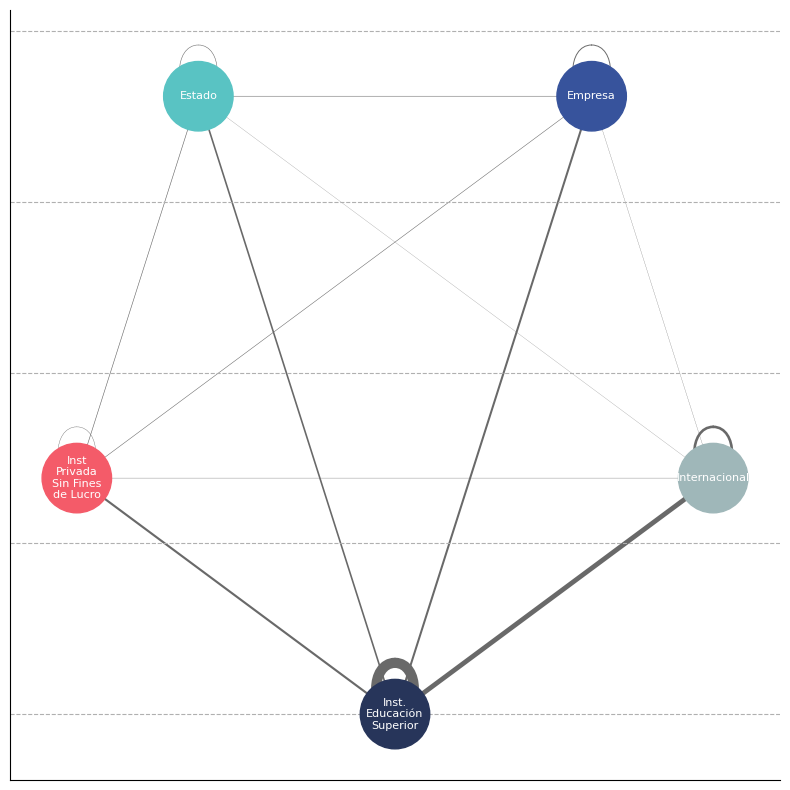

In [12]:
labels = {
  "Institución de Educación Superior": "Inst.\nEducación\nSuperior",
  "Institución Privada Sin Fines de Lucro": "Inst\nPrivada\nSin Fines\nde Lucro",
  "Estado": "Estado",
  "Internacional": "Internacional",
  "Empresa": "Empresa"
}

color_map = {
  "Empresa": COLOR_PALETTE[0],
  "Estado": COLOR_PALETTE[1],
  "Institución Privada Sin Fines de Lucro": COLOR_PALETTE[2],
  "Institución de Educación Superior": BLUE_PALETTE[5],
  "Internacional": COLOR_PALETTE[4],
}
colors = color_map.values()
df_to_plot = df_valid

map_names_inst = get_map_names_institutions(df_valid)
graph = generate_agg_graph(df_to_plot, map_names_inst)
plot_agg_graph(graph, labels=labels, colors=colors, node_size=2500, factor_loops=20, factor_edges=20)

1258it [00:00, 15865.35it/s]
1258it [00:00, 18857.41it/s]
1480it [00:00, 18091.59it/s]
1480it [00:00, 18734.80it/s]
1383it [00:00, 19708.03it/s]
1383it [00:00, 18972.92it/s]
1456it [00:00, 19280.02it/s]
1456it [00:00, 18184.14it/s]
1273it [00:00, 19440.70it/s]
1273it [00:00, 19935.14it/s]
1510it [00:00, 17908.71it/s]
1510it [00:00, 18373.12it/s]
1879it [00:00, 19444.14it/s]
1879it [00:00, 18765.77it/s]
1567it [00:00, 19841.91it/s]
1567it [00:00, 20325.50it/s]


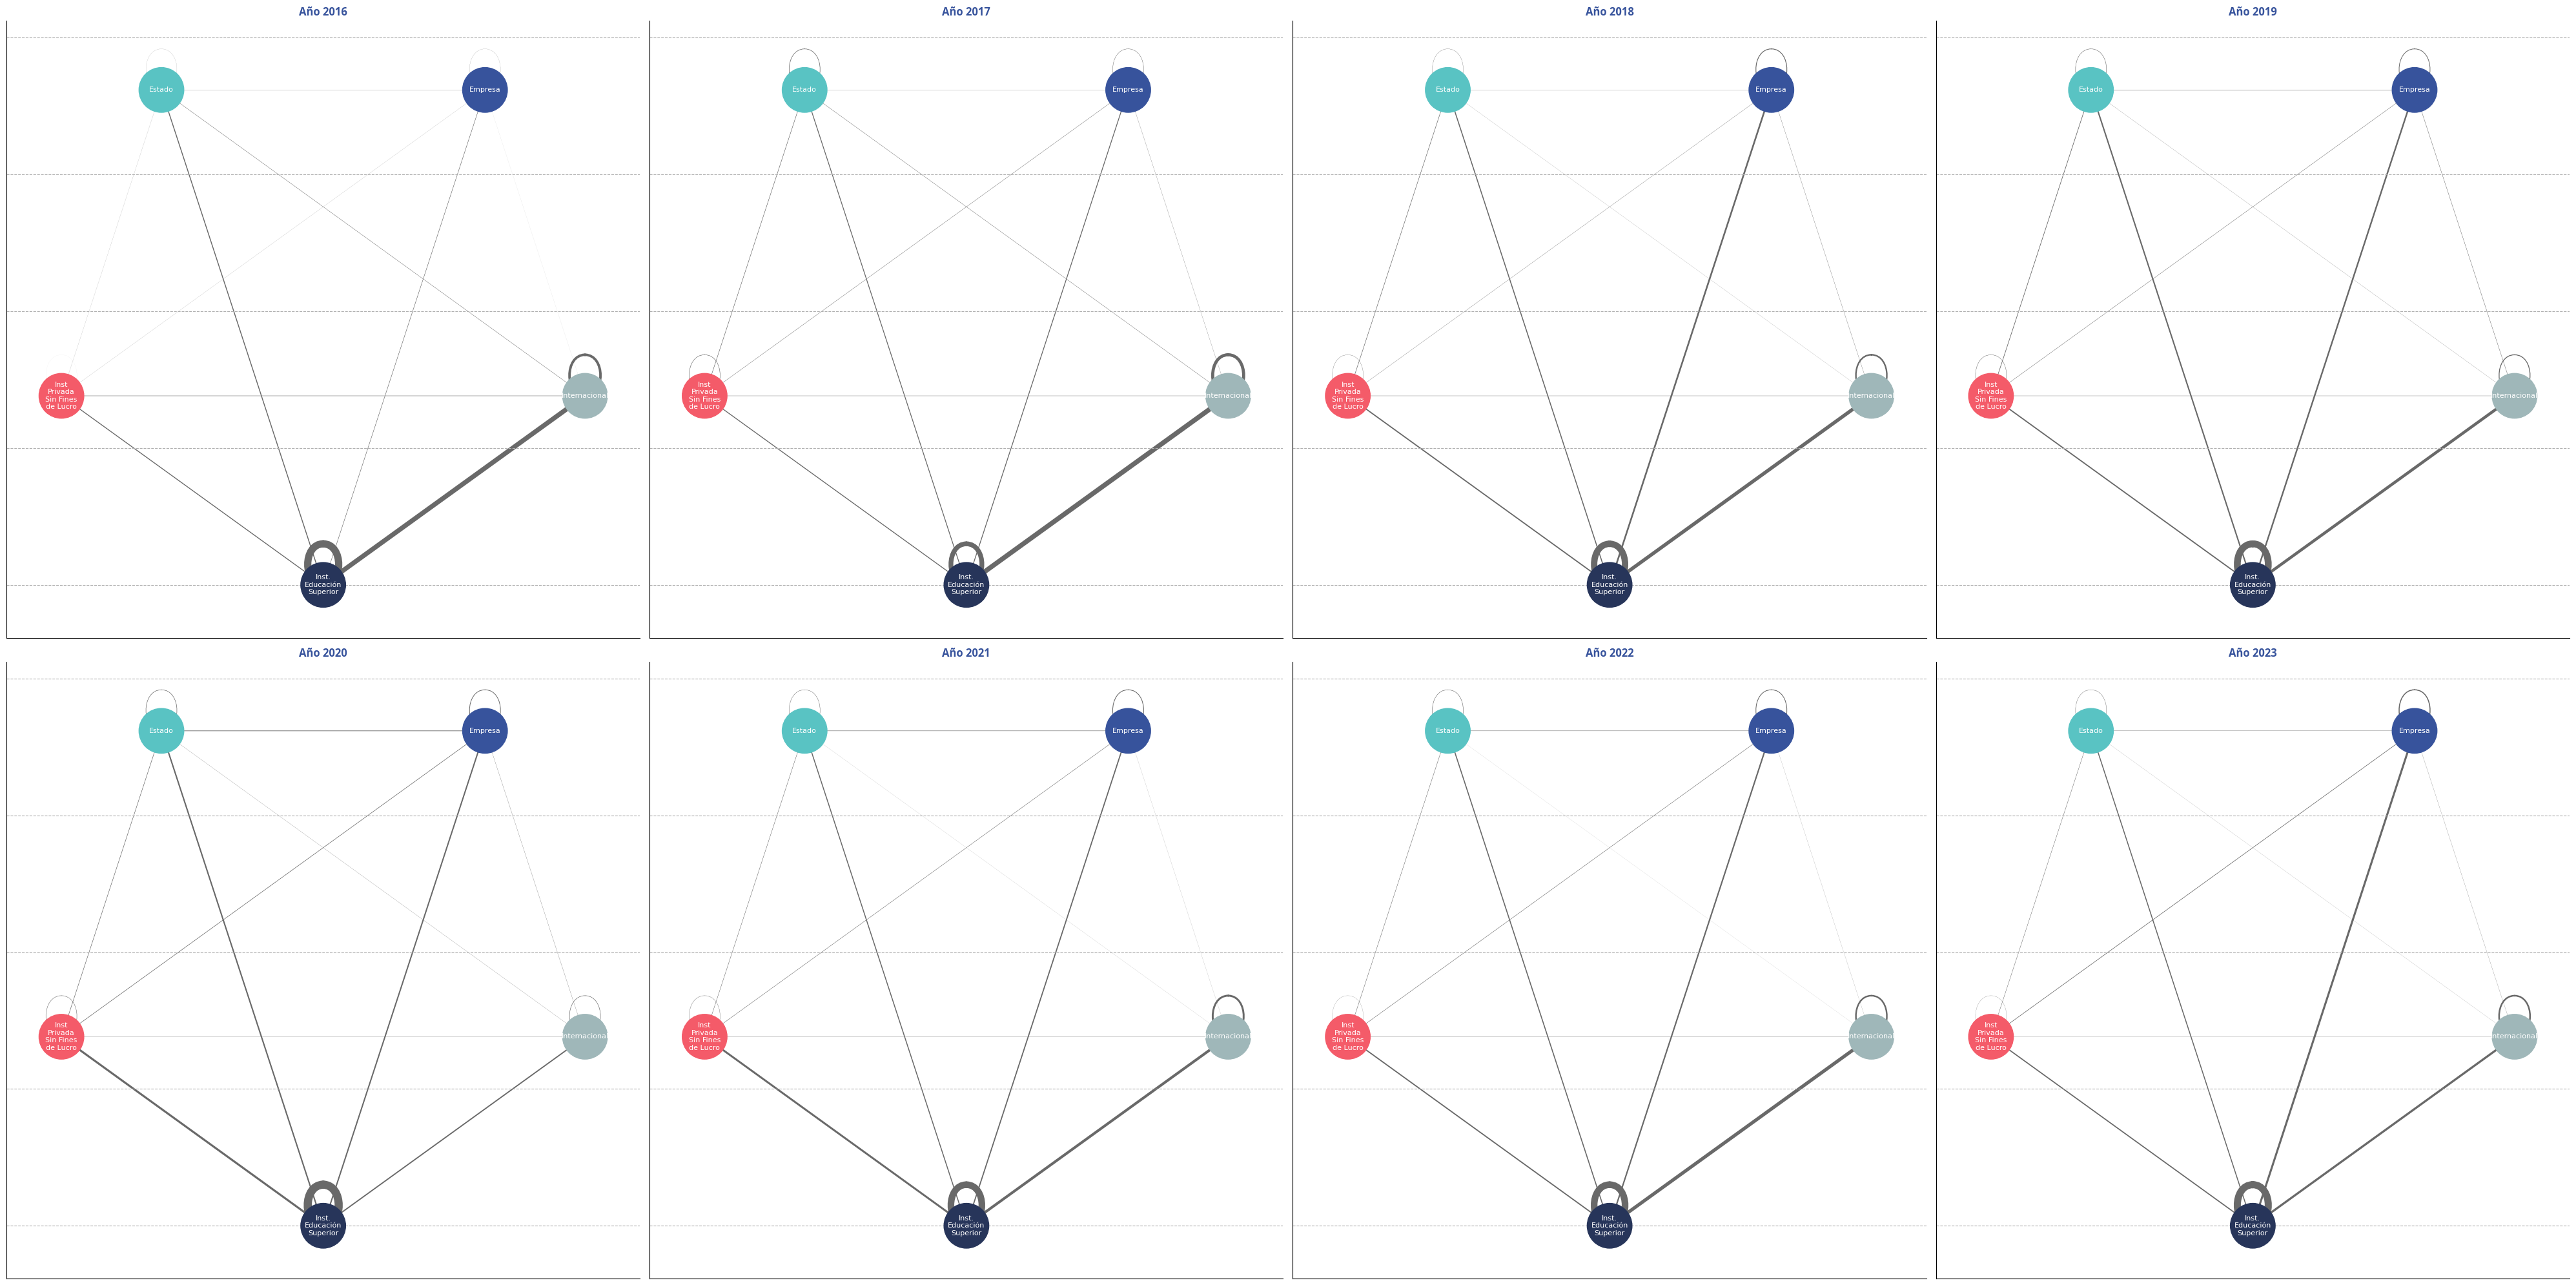

In [13]:
fig, axes = plt.subplots(2, 4, figsize=(40, 20))
counts = {}
for year, ax in zip(range(2016, 2024), axes.flatten()):
  current_df = df_valid.loc[df_valid["AGNOFALLO"] == year]
  current_graph = generate_agg_graph(current_df, map_names_inst)
  counts[year] = count_relations(current_df, normalize=False)
  plot_agg_graph(current_graph, ax=ax, labels=labels, colors=colors, node_size=2500, factor_loops=20, factor_edges=20)
  ax.set_title(f"Año {year}")

#### Gráficos de evolución

In [14]:
inst_types = ["Empresa", "Estado", "Institución Privada Sin Fines de Lucro", "Institución de Educación Superior", "Internacional"]

df_counts = pd.DataFrame(counts).sort_index().reset_index()
## Append symmetrical rows
rows_to_append = []
for iii in range(1, 5):
  for jjj in range(iii):
    current_row = df_counts.loc[(df_counts["level_0"] == inst_types[jjj]) &
                                (df_counts["level_1"] == inst_types[iii]),
                                range(2016, 2024)].values[0]
    current_row = [inst_types[iii], inst_types[jjj]] + list(current_row)
    rows_to_append.append(current_row)
pd.DataFrame(rows_to_append)

df_counts = pd.concat((df_counts, pd.DataFrame(rows_to_append, columns=df_counts.columns)), ignore_index=True)
df_counts

,level_0,level_1,2016,2017,2018,2019,2020,2021,2022,2023
0,Empresa,Empresa,6,56,92,86,93,165,143,111
1,Empresa,Estado,11,35,24,51,90,102,71,31
2,Empresa,Institución Privada Sin Fines de Lucro,5,53,27,42,79,87,77,55
3,Empresa,Institución de Educación Superior,23,165,213,215,198,285,297,220
4,Empresa,Internacional,2,33,27,42,29,22,23,18
5,Estado,Estado,6,96,26,57,78,80,81,37
6,Estado,Institución Privada Sin Fines de Lucro,5,79,54,77,70,84,72,36
7,Estado,Institución de Educación Superior,59,169,133,198,220,249,227,116
8,Estado,Internacional,17,53,13,20,23,18,12,11
9,Institución Privada Sin Fines de Lucro,Institución Privada Sin Fines de Lucro,2,78,30,44,61,63,33,19


<ipython-input-15-7574a0000b2a>:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  current_row = current_df[df_counts["level_1"] == it2].values[0][2:]


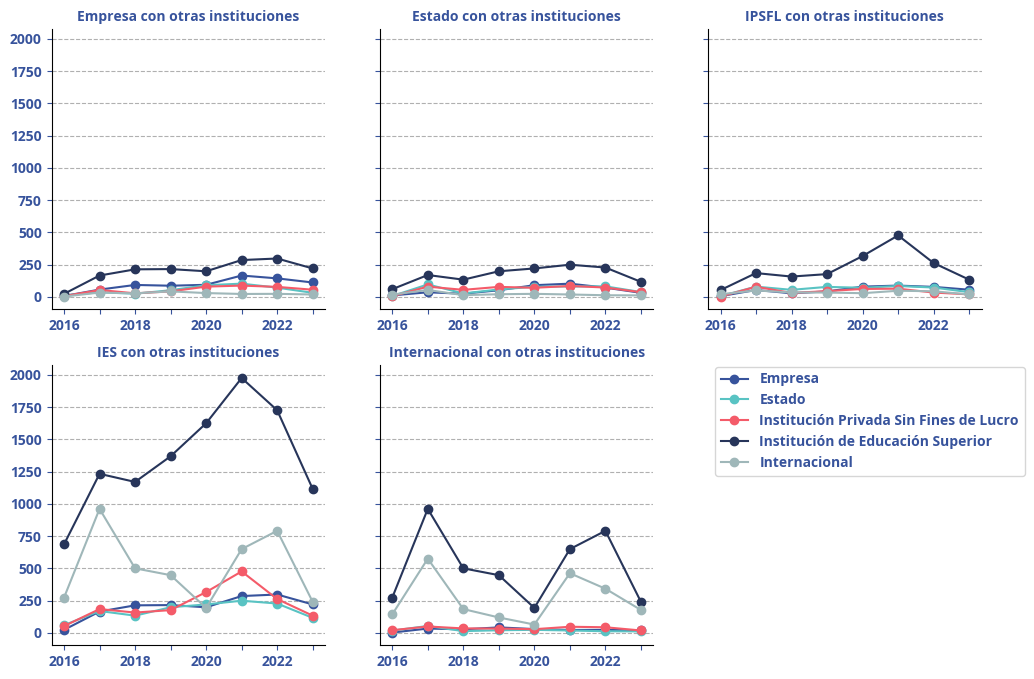

In [15]:
colors = color_map

labels_map = {
    "Empresa": "Empresa",
    "Estado": "Estado",
    "Institución Privada Sin Fines de Lucro": "IPSFL",
    "Institución de Educación Superior": "IES",
    "Internacional": "Internacional"
}

fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharey=True)
for it1, ax in zip(inst_types, axes.flatten()):
  current_df = df_counts[df_counts["level_0"] == it1]
  for it2 in inst_types:
    current_row = current_df[df_counts["level_1"] == it2].values[0][2:]
    ax.plot(current_row, label=it2, color=colors[it2])
    ax.set_title(labels_map[it1] + " con otras instituciones", fontsize=10)
    ax.set_xticks(range(8))
    ax.set_xticklabels([2016, "", 2018, "", 2020, "", 2022, ""])

#_ = fig.suptitle('Número de relaciones entre instituciones, entre 2016 y 2023, según proyectos ANID', fontsize=14, y=0.92)
ax.legend(loc='center left', bbox_to_anchor=(1.2, 0.8))
fig.delaxes(axes[1, 2])

### Grafos complejos (desagregados)

In [16]:
def generate_sparse_graph(df,
                          include_isolated=True,
                          remove_self_loops=True):
  grouped_df = df.groupby("FOLIO").agg({"nombre_canonico": lambda x: x})
  counts = defaultdict(lambda: 0)
  for project_id, row in grouped_df.iterrows():
    institutions = row["nombre_canonico"]
    if type(institutions) == str:
      continue
    if remove_self_loops:
      institutions = set(institutions)
    combinations = itertools.combinations(institutions, 2)
    for (u, v) in combinations:
      counts[(u,v)] += 1

  # Create graph
  graph = nx.Graph()
  names_institution_types = df.groupby("nombre_canonico", as_index=False)["tipo_institucion_final"].first()
  for _, row in names_institution_types.iterrows():
    name = row["nombre_canonico"]
    inst_type = row["tipo_institucion_final"]
    graph.add_node(name, institution_type=inst_type)

  for ((u, v)), count in counts.items():
    graph.add_edge(u, v, weight=count)

  if not include_isolated:
    graph.remove_nodes_from(list(nx.isolates(graph)))
  return graph


In [23]:
def plot_sparse_graph(graph,
                      ax=None,
                      colors=None,
                      fontsize=40,
                      nodesize=40):
  # Generate positions for each subgraph
  company_nodes = [name for name, inst_type in graph.nodes(data="institution_type") if inst_type == "Empresa"]
  state_nodes = [name for name, inst_type in graph.nodes(data="institution_type") if inst_type == "Estado"]
  ies_nodes = [name for name, inst_type in graph.nodes(data="institution_type") if inst_type == "Institución de Educación Superior"]
  ipsfl_nodes = [name for name, inst_type in graph.nodes(data="institution_type") if inst_type == "Institución Privada Sin Fines de Lucro"]
  international_nodes = [name for name, inst_type in graph.nodes(data="institution_type") if inst_type == "Internacional"]

  coords = generate_pentagon(radius=3, rotation=36)
  pos_company = nx.spring_layout(graph.subgraph(company_nodes), center=coords[0])
  pos_state = nx.spring_layout(graph.subgraph(state_nodes), center=coords[1])
  pos_ipsfl = nx.spring_layout(graph.subgraph(ipsfl_nodes), center=coords[2])
  pos_ies = nx.spring_layout(graph.subgraph(ies_nodes), center=coords[3])
  pos_international = nx.spring_layout(graph.subgraph(international_nodes), center=coords[4])

  pos_all = dict(pos_state)
  pos_all.update(pos_ies)
  pos_all.update(pos_ipsfl)
  pos_all.update(pos_company)
  pos_all.update(pos_international)

  # Draw
  if not colors:
    colors = ["tab:blue", "tab:purple", "tab:brown", "tab:olive", "sandybrown"]

  if not ax:
    fig, ax = plt.subplots(1, 1, figsize=(60, 60))

  nx.draw_networkx_nodes(graph, pos=pos_all, nodelist=company_nodes, node_color=colors[0], ax=ax, node_size=nodesize)
  nx.draw_networkx_nodes(graph, pos=pos_all, nodelist=state_nodes, node_color=colors[1], ax=ax, node_size=nodesize)
  nx.draw_networkx_nodes(graph, pos=pos_all, nodelist=ipsfl_nodes, node_color=colors[2], ax=ax, node_size=nodesize)
  nx.draw_networkx_nodes(graph, pos=pos_all, nodelist=ies_nodes, node_color=colors[3], ax=ax, node_size=nodesize)
  nx.draw_networkx_nodes(graph, pos=pos_all, nodelist=international_nodes, node_color=colors[4], ax=ax, node_size=nodesize)

  nx.draw_networkx_edges(graph, pos=pos_all, ax=ax, alpha=0.5, style="dashed", edge_color="silver")

  patch_companies = mpatches.Patch(color=colors[0], label='Empresa')
  patch_state = mpatches.Patch(color=colors[1], label='Estado')
  patch_ipsfl = mpatches.Patch(color=colors[2], label='Institución Privada Sin Fines de Lucro')
  patch_ies = mpatches.Patch(color=colors[3], label='Institución de Educación Superior')
  patch_international = mpatches.Patch(color=colors[4], label='Internacional')
  ax.legend(handles=[patch_companies, patch_state, patch_ipsfl, patch_ies, patch_international], fontsize=fontsize, loc="lower right")
  plt.grid(False)
  plt.tight_layout()

#### Dibujar grafos

##### Con self-loops

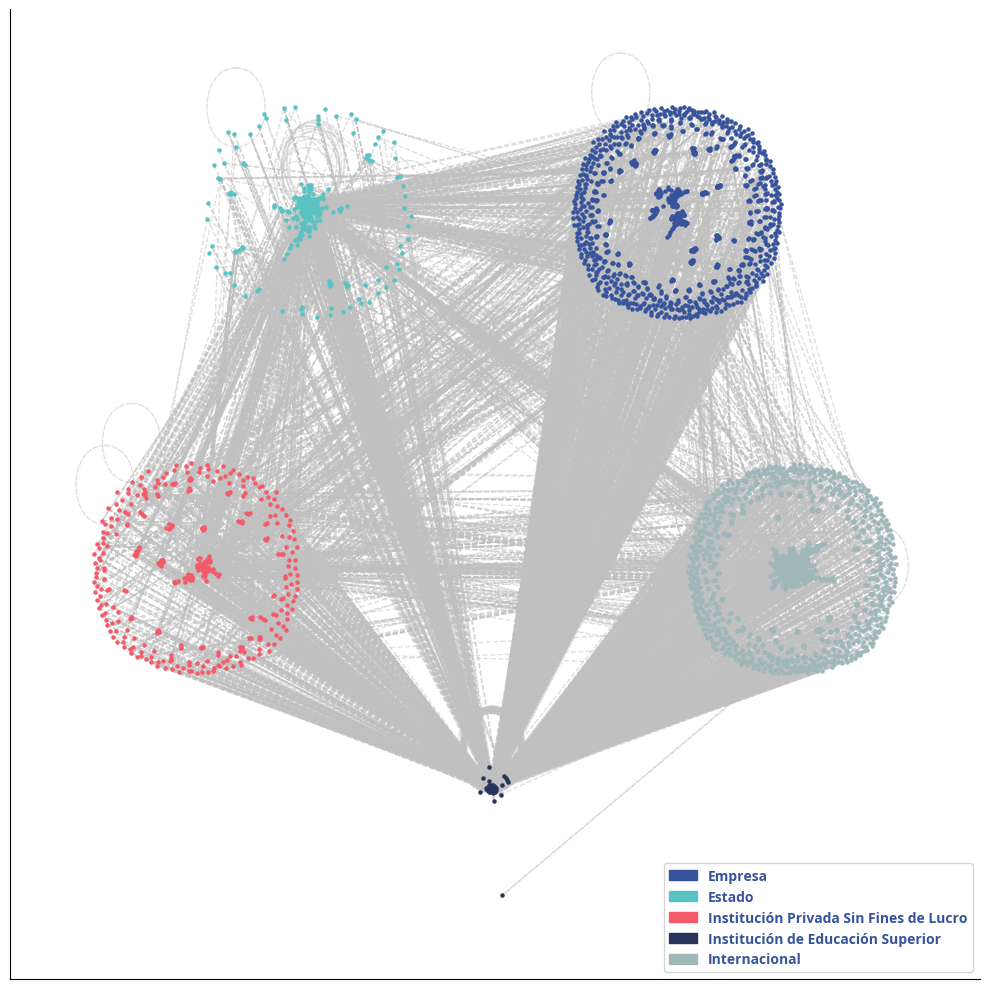

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
graph = generate_sparse_graph(df_valid, remove_self_loops=False)
plot_sparse_graph(graph, ax=ax, fontsize=10, nodesize=5, colors=list(color_map.values()))

##### Sin self-loops

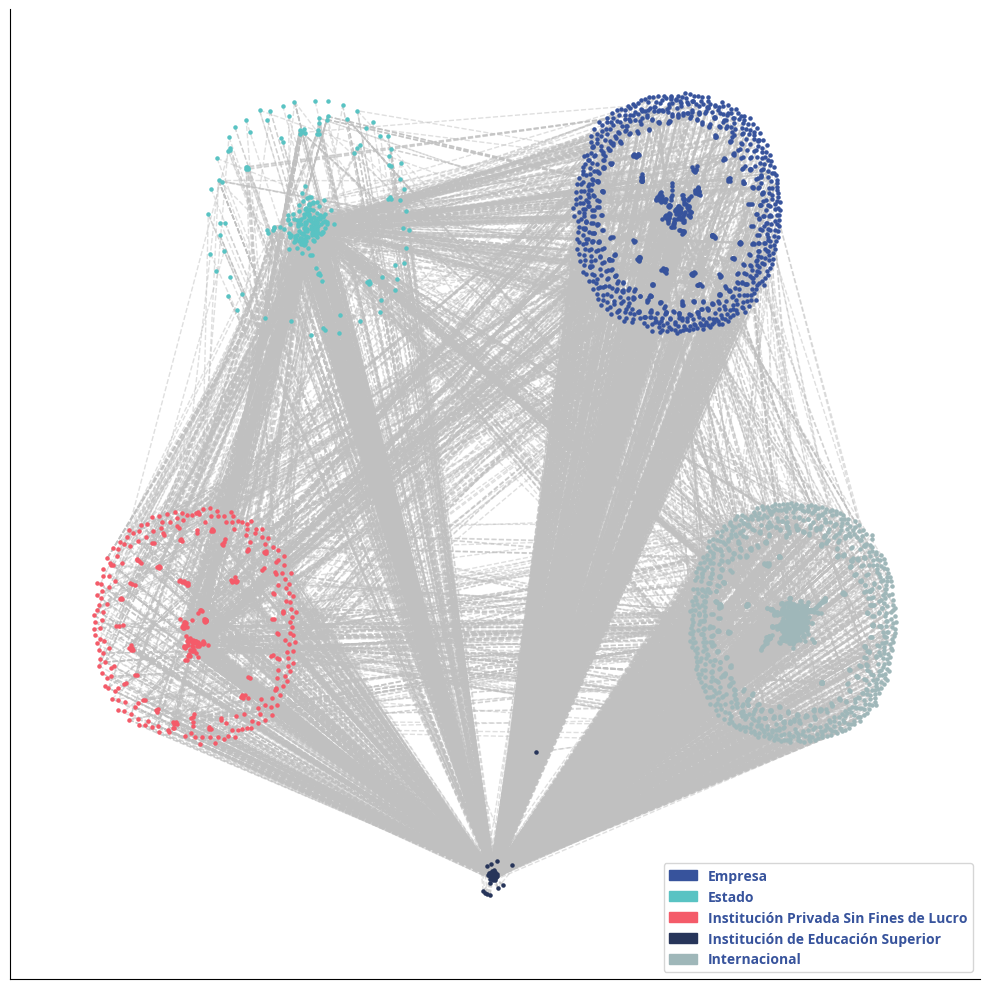

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
graph = generate_sparse_graph(df_valid, remove_self_loops=True)
plot_sparse_graph(graph, ax=ax, fontsize=10, nodesize=5, colors=list(color_map.values()))

##### Sin nodos aislados (y con self-loops)

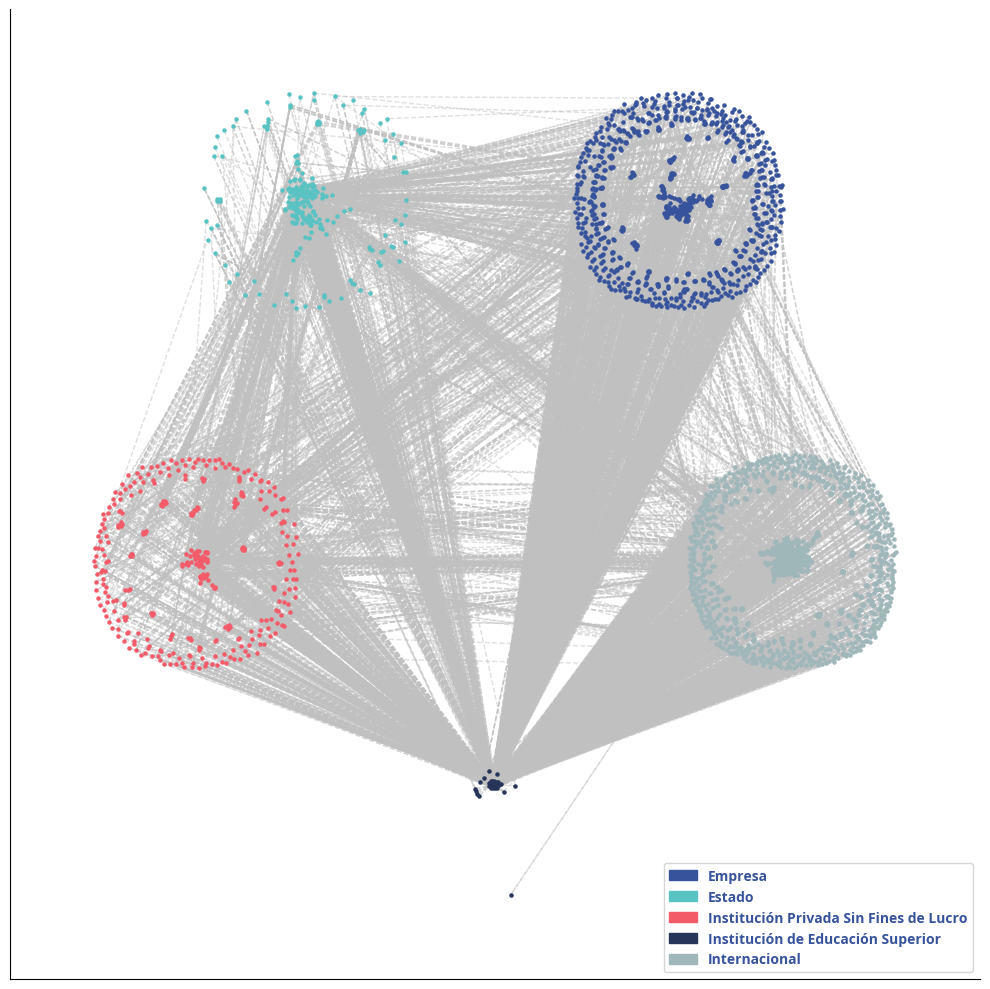

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
graph = generate_sparse_graph(df_valid, include_isolated=False)
plot_sparse_graph(graph, ax=ax, fontsize=10, nodesize=5, colors=list(color_map.values()))

In [27]:
fig, axes = plt.subplots(2, 4, figsize=(40, 20))
for year, ax in zip(range(2016, 2024), axes.flatten()):
  current_df = df_valid.loc[df_valid["AGNOFALLO"] == year]
  current_graph = generate_sparse_graph(current_df, include_isolated=True)
  plot_sparse_graph(current_graph, ax=ax, fontsize=5, nodesize=2, colors=list(color_map.values()))
  ax.set_title(f"Año {year}")


Output hidden; open in https://colab.research.google.com to view.

### Centralidad de grado

In [28]:
def remove_edges_with_type(graph,
                           map_names_inst,
                           remove_type="Institución de Educación Superior"):
  graph_copy = graph.copy()
  to_remove = []
  for (u, v) in graph.edges():
    if map_names_inst[u] == map_names_inst[v] == remove_type:
      to_remove.append((u, v))
  graph_copy.remove_edges_from(to_remove)
  return graph_copy



def calculate_centrality(df, map_names_institutions, remove_ies=False, remove_self_loops=False):
  graph = generate_sparse_graph(df, remove_self_loops=remove_self_loops)
  if remove_ies:
    graph = remove_edges_with_type(graph, map_names_institutions)
  return nx.degree_centrality(graph)

def get_centralities(df, remove_self_loops=False, remove_ies=False, names2inst=None):
  if not names2inst:
    names2inst = get_map_names_institutions(df)
  centralities = {}
  for year in range(2016, 2024):
    current_df = df.loc[df["AGNOFALLO"] == year]
    centralities[year] = calculate_centrality(current_df, names2inst, remove_self_loops=remove_self_loops, remove_ies=remove_ies)

  df_centralities = pd.DataFrame(centralities)
  df_centralities["institución"] = df_centralities.index.to_series().apply(lambda x: names2inst[x])
  return df_centralities

def get_top_centralities(df_cent, df_whole, names2inst, n_top=10):
  all_top = []
  for year in range(2016, 2024):
    top_year_series = df_cent.sort_values(by=year, ascending=False)[:n_top]
    top_names = top_year_series.index.values
    top_values = top_year_series[year].values
    top_institutions = top_year_series["institución"].values
    n_projects = [len(df_whole.loc[(df_whole["nombre_canonico"] == name) & (df_whole["AGNOFALLO"] == year), "FOLIO"].unique())
                    for name in top_names]
    all_top.append(top_names)
    all_top.append(top_values)
    all_top.append(top_institutions)
    all_top.append(n_projects)
  column_names = itertools.chain.from_iterable([(f"nombres_{year}", f"centralidad_{year}", f"instituciones_{year}", f"n_proyectos_{year}") for year in range(2016, 2024)])
  return pd.DataFrame(np.array(all_top).T, columns=column_names)

def get_top_centralities_filtered(df_cent, df_whole, names2inst, n_top=10):
  all_top = []
  for year in range(2016, 2024):
    top_year_series = df_cent[df_cent["institución"] != "Institución de Educación Superior"].sort_values(by=year, ascending=False)[:n_top]
    top_names = top_year_series.index.values
    top_values = top_year_series[year].values
    top_institutions = top_year_series["institución"].values
    n_projects = [len(df_whole.loc[(df_whole["nombre_canonico"] == name) & (df_whole["AGNOFALLO"] == year), "FOLIO"].unique())
                    for name in top_names]
    all_top.append(top_names)
    all_top.append(top_values)
    all_top.append(top_institutions)
    all_top.append(n_projects)
  column_names = itertools.chain.from_iterable([(f"nombres_{year}", f"centralidad_{year}", f"instituciones_{year}", f"n_proyectos_{year}") for year in range(2016, 2024)])
  return pd.DataFrame(np.array(all_top).T, columns=column_names)

In [29]:
names2inst = get_map_names_institutions(df_valid)

In [30]:
df_cent = get_centralities(df_valid, names2inst=names2inst)
df_cent_no_loops = get_centralities(df_valid, names2inst=names2inst, remove_self_loops=True)
df_cent_no_ies = get_centralities(df_valid, names2inst=names2inst, remove_ies=True)


In [31]:
x = get_top_centralities(df_cent_no_ies, df_valid, names2inst=names2inst)
x

,nombres_2016,centralidad_2016,instituciones_2016,n_proyectos_2016,nombres_2017,centralidad_2017,instituciones_2017,n_proyectos_2017,nombres_2018,centralidad_2018,...,instituciones_2021,n_proyectos_2021,nombres_2022,centralidad_2022,instituciones_2022,n_proyectos_2022,nombres_2023,centralidad_2023,instituciones_2023,n_proyectos_2023
0,UNIVERSIDAD DE CHILE,0.184524,Institución de Educación Superior,286,UNIVERSIDAD DE CHILE,0.246851,Institución de Educación Superior,316,UNIVERSIDAD DE CHILE,0.203583,...,Institución de Educación Superior,331,UNIVERSIDAD DE CHILE,0.194839,Institución de Educación Superior,360,UNIVERSIDAD DE CHILE,0.178971,Institución de Educación Superior,261
1,PONTIFICIA UNIVERSIDAD CATOLICA DE CHILE,0.142857,Institución de Educación Superior,228,UNIVERSIDAD DE CONCEPCION,0.187657,Institución de Educación Superior,178,PONTIFICIA UNIVERSIDAD CATOLICA DE CHILE,0.138436,...,Institución de Educación Superior,162,UNIVERSIDAD DE CONCEPCION,0.166452,Institución de Educación Superior,197,PONTIFICIA UNIVERSIDAD CATOLICA DE CHILE,0.161074,Institución de Educación Superior,262
2,UNIVERSIDAD DE CONCEPCION,0.077381,Institución de Educación Superior,131,PONTIFICIA UNIVERSIDAD CATOLICA DE CHILE,0.177582,Institución de Educación Superior,281,UNIVERSIDAD DE CONCEPCION,0.120521,...,Institución de Educación Superior,261,PONTIFICIA UNIVERSIDAD CATOLICA DE CHILE,0.117419,Institución de Educación Superior,296,UNIVERSIDAD DE CONCEPCION,0.129754,Institución de Educación Superior,155
3,UNIVERSIDAD AUSTRAL DE CHILE,0.065476,Institución de Educación Superior,64,UNIVERSIDAD DE LA FRONTERA,0.079345,Institución de Educación Superior,84,UNIVERSIDAD DE SANTIAGO DE CHILE,0.087948,...,Institución de Educación Superior,105,UNIVERSIDAD AUSTRAL DE CHILE,0.113548,Institución de Educación Superior,141,UNIVERSIDAD DE LA FRONTERA,0.080537,Institución de Educación Superior,86
4,UNIVERSIDAD NACIONAL ANDRES BELLO,0.0625,Institución de Educación Superior,59,PONTIFICIA UNIVERSIDAD CATOLICA DE VALPARAISO,0.073048,Institución de Educación Superior,90,UNIVERSIDAD TECNICA FEDERICO SANTA MARIA,0.084691,...,Institución de Educación Superior,97,UNIVERSIDAD TECNICA FEDERICO SANTA MARIA,0.091613,Institución de Educación Superior,75,PONTIFICIA UNIVERSIDAD CATOLICA DE VALPARAISO,0.073826,Institución de Educación Superior,112
5,UNIVERSIDAD DE TALCA,0.0625,Institución de Educación Superior,48,UNIVERSIDAD AUSTRAL DE CHILE,0.071788,Institución de Educación Superior,99,UNIVERSIDAD AUSTRAL DE CHILE,0.070033,...,Institución de Educación Superior,105,PONTIFICIA UNIVERSIDAD CATOLICA DE VALPARAISO,0.087742,Institución de Educación Superior,114,UNIVERSIDAD DE SANTIAGO DE CHILE,0.069351,Institución de Educación Superior,86
6,PONTIFICIA UNIVERSIDAD CATOLICA DE VALPARAISO,0.056548,Institución de Educación Superior,70,UNIVERSIDAD TECNICA FEDERICO SANTA MARIA,0.056675,Institución de Educación Superior,71,UNIVERSIDAD DE LA FRONTERA,0.068404,...,Institución Privada Sin Fines de Lucro,25,UNIVERSIDAD DE LA FRONTERA,0.067097,Institución de Educación Superior,87,UNIVERSIDAD CATOLICA DE LA SANTISIMA CONCEPCION,0.060403,Institución de Educación Superior,35
7,UNIVERSIDAD TECNICA FEDERICO SANTA MARIA,0.047619,Institución de Educación Superior,64,UNIVERSIDAD DE SANTIAGO DE CHILE,0.052897,Institución de Educación Superior,107,PONTIFICIA UNIVERSIDAD CATOLICA DE VALPARAISO,0.057003,...,Institución de Educación Superior,74,UNIVERSIDAD DE TALCA,0.064516,Institución de Educación Superior,76,UNIVERSIDAD TECNICA FEDERICO SANTA MARIA,0.053691,Institución de Educación Superior,72
8,INSTITUTO DE INVESTIGACIONES AGROPECUARIAS,0.047619,Estado,15,UNIVERSIDAD DIEGO PORTALES,0.051637,Institución de Educación Superior,45,UNIVERSIDAD CATOLICA DEL NORTE,0.04886,...,Institución de Educación Superior,58,UNIVERSIDAD DE SANTIAGO DE CHILE,0.058065,Institución de Educación Superior,107,UNIVERSIDAD AUSTRAL DE CHILE,0.051454,Institución de Educación Superior,93
9,SERVICIO NACIONAL DEL ADULTO MAYOR,0.041667,Estado,4,UNIVER

In [32]:
for year in range(2016, 2024):
    print(year)
    display(x.loc[x[f"instituciones_{year}"] != "Institución de Educación Superior", [f"nombres_{year}", f"instituciones_{year}"]])

2016


,nombres_2016,instituciones_2016
8,INSTITUTO DE INVESTIGACIONES AGROPECUARIAS,Estado
9,SERVICIO NACIONAL DEL ADULTO MAYOR,Estado


2017


,nombres_2017,instituciones_2017


2018


,nombres_2018,instituciones_2018


2019


,nombres_2019,instituciones_2019
8,INSTITUTO DE INVESTIGACIONES AGROPECUARIAS,Estado


2020


,nombres_2020,instituciones_2020
4,SUBSECRETARIA DEL MINISTERIO DE AGRICULT,Estado
5,CENTRO DE ESTUDIOS AVANZADOS EN ZONAS ARIDAS,Institución Privada Sin Fines de Lucro
9,RED UNIVERSITARIA NACIONAL,Institución Privada Sin Fines de Lucro


2021


,nombres_2021,instituciones_2021
6,CENTRO DE ESTUDIOS AVANZADOS EN ZONAS ARIDAS,Institución Privada Sin Fines de Lucro


2022


,nombres_2022,instituciones_2022


2023


,nombres_2023,instituciones_2023


In [33]:
x[[f"nombres_{year}" for year in range(2016, 2024)]]

,nombres_2016,nombres_2017,nombres_2018,nombres_2019,nombres_2020,nombres_2021,nombres_2022,nombres_2023
0,UNIVERSIDAD DE CHILE,UNIVERSIDAD DE CHILE,UNIVERSIDAD DE CHILE,UNIVERSIDAD DE CHILE,UNIVERSIDAD DE CHILE,UNIVERSIDAD DE CHILE,UNIVERSIDAD DE CHILE,UNIVERSIDAD DE CHILE
1,PONTIFICIA UNIVERSIDAD CATOLICA DE CHILE,UNIVERSIDAD DE CONCEPCION,PONTIFICIA UNIVERSIDAD CATOLICA DE CHILE,PONTIFICIA UNIVERSIDAD CATOLICA DE CHILE,UNIVERSIDAD DE CONCEPCION,UNIVERSIDAD DE CONCEPCION,UNIVERSIDAD DE CONCEPCION,PONTIFICIA UNIVERSIDAD CATOLICA DE CHILE
2,UNIVERSIDAD DE CONCEPCION,PONTIFICIA UNIVERSIDAD CATOLICA DE CHILE,UNIVERSIDAD DE CONCEPCION,UNIVERSIDAD DE CONCEPCION,PONTIFICIA UNIVERSIDAD CATOLICA DE CHILE,PONTIFICIA UNIVERSIDAD CATOLICA DE CHILE,PONTIFICIA UNIVERSIDAD CATOLICA DE CHILE,UNIVERSIDAD DE CONCEPCION
3,UNIVERSIDAD AUSTRAL DE CHILE,UNIVERSIDAD DE LA FRONTERA,UNIVERSIDAD DE SANTIAGO DE CHILE,UNIVERSIDAD TECNICA FEDERICO SANTA MARIA,UNIVERSIDAD AUSTRAL DE CHILE,PONTIFICIA UNIVERSIDAD CATOLICA DE VALPARAISO,UNIVERSIDAD AUSTRAL DE CHILE,UNIVERSIDAD DE LA FRONTERA
4,UNIVERSIDAD NACIONAL ANDRES BELLO,PONTIFICIA UNIVERSIDAD CATOLICA DE VALPARAISO,UNIVERSIDAD TECNICA FEDERICO SANTA MARIA,UNIVERSIDAD DE LA FRONTERA,SUBSECRETARIA DEL MINISTERIO DE AGRICULT,UNIVERSIDAD AUSTRAL DE CHILE,UNIVERSIDAD TECNICA FEDERICO SANTA MARIA,PONTIFICIA UNIVERSIDAD CATOLICA DE VALPARAISO
5,UNIVERSIDAD DE TALCA,UNIVERSIDAD AUSTRAL DE CHILE,UNIVERSIDAD AUSTRAL DE CHILE,UNIVERSIDAD AUSTRAL DE CHILE,CENTRO DE ESTUDIOS AVANZADOS EN ZONAS ARIDAS,UNIVERSIDAD DE SANTIAGO DE CHILE,PONTIFICIA UNIVERSIDAD CATOLICA DE VALPARAISO,UNIVERSIDAD DE SANTIAGO DE CHILE
6,PONTIFICIA UNIVERSIDAD CATOLICA DE VALPARAISO,UNIVERSIDAD TECNICA FEDERICO SANTA MARIA,UNIVERSIDAD DE LA FRONTERA,UNIVERSIDAD DE SANTIAGO DE CHILE,PONTIFICIA UNIVERSIDAD CATOLICA DE VALPARAISO,CENTRO DE ESTUDIOS AVANZADOS EN ZONAS ARIDAS,UNIVERSIDAD DE LA FRONTERA,UNIVERSIDAD CATOLICA DE LA SANTISIMA CONCEPCION
7,UNIVERSIDAD TECNICA FEDERICO SANTA MARIA,UNIVERSIDAD DE SANTIAGO DE CHILE,PONTIFICIA UNIVERSIDAD CATOLICA DE VALPARAISO,PONTIFICIA UNIVERSIDAD CATOLICA DE VALPARAISO,UNIVERSIDAD DE LA FRONTERA,UNIVERSIDAD TECNICA FEDERICO SANTA MARIA,UNIVERSIDAD DE TALCA,UNIVERSIDAD TECNICA FEDERICO SANTA MARIA
8,INSTITUTO DE INVESTIGACIONES AGROPECUARIAS,UNIVERSIDAD DIEGO PORTALES,UNIVERSIDAD CATOLICA DEL NORTE,INSTITUTO DE INVESTIGACIONES AGROPECUARIAS,UNIVERSIDAD CATOLICA DEL NORTE,UNIVERSIDAD CATOLICA DEL NORTE,UNIVERSIDAD DE SANTIAGO DE CHILE,UNIVERSIDAD AUSTRAL DE CHILE
9,SERVICIO NACIONAL DEL ADULTO MAYOR,UNIVERSIDAD DE LOS LAGOS,UNIVERSIDAD DE TALCA,UNIVERSIDAD DEL BIO BIO,RED UNIVERSITARIA NACIONAL,UNIVERSIDAD DE LA FRONTERA,UNIVERSIDAD NACIONAL ANDRES BELLO,UNIVERSIDAD DE VALPARAISO


In [34]:
new_rows = {}
for year in range(2016, 2024):
  new_rows[year] = x.apply(lambda row: row[f"nombres_{year}"].title() + ' (' + f'{row[f"centralidad_{year}"]:.2f}, N={row[f"n_proyectos_{year}"]}' + ')', axis=1)

In [35]:
y = pd.DataFrame(new_rows)
y

,2016,2017,2018,2019,2020,2021,2022,2023
0,"Universidad De Chile (0.18, N=286)","Universidad De Chile (0.25, N=316)","Universidad De Chile (0.20, N=269)","Universidad De Chile (0.22, N=306)","Universidad De Chile (0.23, N=291)","Universidad De Chile (0.21, N=331)","Universidad De Chile (0.19, N=360)","Universidad De Chile (0.18, N=261)"
1,Pontificia Universidad Catolica De Chile (0.14...,"Universidad De Concepcion (0.19, N=178)",Pontificia Universidad Catolica De Chile (0.14...,Pontificia Universidad Catolica De Chile (0.14...,"Universidad De Concepcion (0.21, N=144)","Universidad De Concepcion (0.16, N=162)","Universidad De Concepcion (0.17, N=197)",Pontificia Universidad Catolica De Chile (0.16...
2,"Universidad De Concepcion (0.08, N=131)",Pontificia Universidad Catolica De Chile (0.18...,"Universidad De Concepcion (0.12, N=139)","Universidad De Concepcion (0.10, N=157)",Pontificia Universidad Catolica De Chile (0.15...,Pontificia Universidad Catolica De Chile (0.15...,Pontificia Universidad Catolica De Chile (0.12...,"Universidad De Concepcion (0.13, N=155)"
3,"Universidad Austral De Chile (0.07, N=64)","Universidad De La Frontera (0.08, N=84)","Universidad De Santiago De Chile (0.09, N=85)",Universidad Tecnica Federico Santa Maria (0.08...,"Universidad Austral De Chile (0.14, N=78)",Pontificia Universidad Catolica De Valparaiso ...,"Universidad Austral De Chile (0.11, N=141)","Universidad De La Frontera (0.08, N=86)"
4,"Universidad Nacional Andres Bello (0.06, N=59)",Pontificia Universidad Catolica De Valparaiso ...,Universidad Tecnica Federico Santa Maria (0.08...,"Universidad De La Frontera (0.08, N=80)",Subsecretaria Del Ministerio De Agricult (0.10...,"Universidad Austral De Chile (0.10, N=97)",Universidad Tecnica Federico Santa Maria (0.09...,Pontificia Universidad Catolica De Valparaiso ...
5,"Universidad De Talca (0.06, N=48)","Universidad Austral De Chile (0.07, N=99)","Universidad Austral De Chile (0.07, N=74)","Universidad Austral De Chile (0.07, N=90)",Centro De Estudios Avanzados En Zonas Aridas (...,"Universidad De Santiago De Chile (0.09, N=105)",Pontificia Universidad Catolica De Valparaiso ...,"Universidad De Santiago De Chile (0.07, N=86)"
6,Pontificia Universidad Catolica De Valparaiso ...,Universidad Tecnica Federico Santa Maria (0.06...,"Universidad De La Frontera (0.07, N=69)","Universidad De Santiago De Chile (0.06, N=92)",Pontificia Universidad Catolica De Valparaiso ...,Centro De Estudios Avanzados En Zonas Aridas (...,"Universidad De La Frontera (0.07, N=87)",Universidad Catolica De La Santisima Concepcio...
7,Universidad Tecnica Federico Santa Maria (0.05...,"Universidad De Santiago De Chile (0.05, N=107)",Pontificia Universidad Catolica De Valparaiso ...,Pontificia Universidad Catolica De Valparaiso ...,"Universidad De La Frontera (0.09, N=64)",Universidad Tecnica Federico Santa Maria (0.08...,"Universidad De Talca (0.06, N=76)",Universidad Tecnica Federico Santa Maria (0.05...
8,Instituto De Investigaciones Agropecuarias (0....,"Universidad Diego Portales (0.05, N=45)","Universidad Catolica Del Norte (0.05, N=47)",Instituto De Investigaciones Agropecuarias (0....,"Universidad Catolica Del Norte (0.08, N=33)","Universidad Catolica Del Norte (0.08, N=58)","Universidad De Santiago De Chile (0.06, N=107)","Universidad Austral De Chile (0.05, N=93)"
9,"Servicio Nacional Del Adulto Mayor (0.04, N=4)","Universidad De Los Lagos (0.05, N=27)","Universidad De Talca (0.04, N=51)","Universidad Del Bio Bio (0.04, N=45)","Red Universitaria Nacional (0.07, N=2)","Universidad De La Frontera (0.07, N=93)","Universidad Nacional Andres Bello (0.06, N=91)","Universidad De Valparaiso (0.05, N=60)"


In [36]:
to_replace = {
    "Universidad De Chile": "U Chile",
    "Pontificia Universidad Catolica De Chile": "PUC",
    "Universidad De Concepcion": "UDEC",
    "Universidad Austral De Chile": "U Austral",
    "Universidad Nacional Andres Bello": "UNAB",
    "Universidad De Talca": "U Talca",
    "Universidad Tecnica Federico Santa Maria": "UTFSM",
    "Universidad De La Frontera": "UFRO",
    "Pontificia Universidad Catolica De Valparaiso": "PUCV",
    "Universidad De Santiago De Chile": "USACH",
    "Universidad Diego Portales": "UDP",
    "Universidad De Los Lagos": "U Los Lagos",
    "Universidad Catolica Del Norte": "UCN",
    "Universidad Catolica De La Santisima Concepcion": "UCSC",
    "Universidad De Valparaiso": "UV",
    "Universidad Del Bio Bio": "U Bío Bío",
    "Centro De Estudios Avanzados En Zonas Aridas": "CEAZA"
}
z = y.copy()
for k, v in to_replace.items():
  z = z.replace(k,v, regex=True)
z

,2016,2017,2018,2019,2020,2021,2022,2023
0,"U Chile (0.18, N=286)","U Chile (0.25, N=316)","U Chile (0.20, N=269)","U Chile (0.22, N=306)","U Chile (0.23, N=291)","U Chile (0.21, N=331)","U Chile (0.19, N=360)","U Chile (0.18, N=261)"
1,"PUC (0.14, N=228)","UDEC (0.19, N=178)","PUC (0.14, N=231)","PUC (0.14, N=241)","UDEC (0.21, N=144)","UDEC (0.16, N=162)","UDEC (0.17, N=197)","PUC (0.16, N=262)"
2,"UDEC (0.08, N=131)","PUC (0.18, N=281)","UDEC (0.12, N=139)","UDEC (0.10, N=157)","PUC (0.15, N=235)","PUC (0.15, N=261)","PUC (0.12, N=296)","UDEC (0.13, N=155)"
3,"U Austral (0.07, N=64)","UFRO (0.08, N=84)","USACH (0.09, N=85)","UTFSM (0.08, N=84)","U Austral (0.14, N=78)","PUCV (0.11, N=105)","U Austral (0.11, N=141)","UFRO (0.08, N=86)"
4,"UNAB (0.06, N=59)","PUCV (0.07, N=90)","UTFSM (0.08, N=78)","UFRO (0.08, N=80)",Subsecretaria Del Ministerio De Agricult (0.10...,"U Austral (0.10, N=97)","UTFSM (0.09, N=75)","PUCV (0.07, N=112)"
5,"U Talca (0.06, N=48)","U Austral (0.07, N=99)","U Austral (0.07, N=74)","U Austral (0.07, N=90)","CEAZA (0.09, N=12)","USACH (0.09, N=105)","PUCV (0.09, N=114)","USACH (0.07, N=86)"
6,"PUCV (0.06, N=70)","UTFSM (0.06, N=71)","UFRO (0.07, N=69)","USACH (0.06, N=92)","PUCV (0.09, N=63)","CEAZA (0.09, N=25)","UFRO (0.07, N=87)","UCSC (0.06, N=35)"
7,"UTFSM (0.05, N=64)","USACH (0.05, N=107)","PUCV (0.06, N=96)","PUCV (0.05, N=99)","UFRO (0.09, N=64)","UTFSM (0.08, N=74)","U Talca (0.06, N=76)","UTFSM (0.05, N=72)"
8,Instituto De Investigaciones Agropecuarias (0....,"UDP (0.05, N=45)","UCN (0.05, N=47)",Instituto De Investigaciones Agropecuarias (0....,"UCN (0.08, N=33)","UCN (0.08, N=58)","USACH (0.06, N=107)","U Austral (0.05, N=93)"
9,"Servicio Nacional Del Adulto Mayor (0.04, N=4)","U Los Lagos (0.05, N=27)","U Talca (0.04, N=51)","U Bío Bío (0.04, N=45)","Red Universitaria Nacional (0.07, N=2)","UFRO (0.07, N=93)","UNAB (0.06, N=91)","UV (0.05, N=60)"


In [ ]:
z

,2016,2017,2018,2019,2020,2021,2022,2023
0,U Chile (0.18),U Chile (0.25),U Chile (0.20),U Chile (0.22),U Chile (0.23),U Chile (0.21),U Chile (0.19),U Chile (0.18)
1,PUC (0.14),UDEC (0.19),PUC (0.14),PUC (0.14),UDEC (0.21),UDEC (0.16),UDEC (0.17),PUC (0.16)
2,UDEC (0.08),PUC (0.18),UDEC (0.12),UDEC (0.10),PUC (0.15),PUC (0.15),PUC (0.12),UDEC (0.13)
3,U Austral (0.07),UFRO (0.08),USACH (0.09),UTFSM (0.08),U Austral (0.14),PUCV (0.11),U Austral (0.11),UFRO (0.08)
4,UNAB (0.06),PUCV (0.07),UTFSM (0.08),UFRO (0.08),Subsecretaria Del Ministerio De Agricult (0.10),U Austral (0.10),UTFSM (0.09),PUCV (0.07)
5,U Talca (0.06),U Austral (0.07),U Austral (0.07),U Austral (0.07),CEAZA (0.09),USACH (0.09),PUCV (0.09),USACH (0.07)
6,PUCV (0.06),UTFSM (0.06),UFRO (0.07),USACH (0.06),PUCV (0.09),CEAZA (0.09),UFRO (0.07),UCSC (0.06)
7,UTFSM (0.05),USACH (0.05),PUCV (0.06),PUCV (0.05),UFRO (0.09),UTFSM (0.08),U Talca (0.06),UTFSM (0.05)
8,Instituto De Investigaciones Agropecuarias (0.05),UDP (0.05),UCN (0.05),Instituto De Investigaciones Agropecuarias (0.04),UCN (0.08),UCN (0.08),USACH (0.06),U Austral (0.05)
9,Servicio Nacional Del Adulto Mayor (0.04),U Los Lagos (0.05),U Talca (0.04),Universidad Del Bio Bio (0.04),Red Universitaria Nacional (0.07),UFRO (0.07),UNAB (0.06),UV (0.05)


In [ ]:
get_top_centralities_filtered(df_cent_no_ies, names2inst=names2inst)

,nombres_2016,centralidad_2016,instituciones_2016,nombres_2017,centralidad_2017,instituciones_2017,nombres_2018,centralidad_2018,instituciones_2018,nombres_2019,...,instituciones_2020,nombres_2021,centralidad_2021,instituciones_2021,nombres_2022,centralidad_2022,instituciones_2022,nombres_2023,centralidad_2023,instituciones_2023
0,INSTITUTO DE INVESTIGACIONES AGROPECUARIAS,0.047619,Estado,CORP. REG.. AYSEN DE INV. Y DES. COOPER. CENTR...,0.04534,Institución Privada Sin Fines de Lucro,CORP. REG.. AYSEN DE INV. Y DES. COOPER. CENTR...,0.030945,Institución Privada Sin Fines de Lucro,INSTITUTO DE INVESTIGACIONES AGROPECUARIAS,...,Estado,CENTRO DE ESTUDIOS AVANZADOS EN ZONAS ARIDAS,0.085642,Institución Privada Sin Fines de Lucro,UNIVERSIDAD DE LA REPUBLICA URUGUAY,0.042581,Internacional,CENTRO DE ESTUDIOS AVANZADOS EN ZONAS ARIDAS,0.049217,Institución Privada Sin Fines de Lucro
1,SERVICIO NACIONAL DEL ADULTO MAYOR,0.041667,Estado,INSTITUTO DE INVESTIGACIONES AGROPECUARIAS,0.042821,Estado,CENTRO DE ESTUDIOS AVANZADOS EN ZONAS ARIDAS,0.02443,Institución Privada Sin Fines de Lucro,CENTRO DE ESTUDIOS AVANZADOS EN ZONAS ARIDAS,...,Institución Privada Sin Fines de Lucro,MINISTERIO DE OBRAS PUBLICAS DIREC CION GRAL D...,0.052897,Estado,INSTITUTO DE INVESTIGACIONES AGROPECUARIAS,0.037419,Estado,INSTITUTO DE INVESTIGACIONES AGROPECUARIAS,0.04698,Estado
2,COMISION NACIONAL DE ENERGIA ATOMICA,0.020833,Internacional,CORP NACIONAL FORESTAL,0.039043,Estado,OFICINA NACIONAL DE EMERGENCIA DEL MINIS,0.022801,Estado,CORP NACIONAL FORESTAL,...,Institución Privada Sin Fines de Lucro,INSTITUTO DE INVESTIGACIONES AGROPECUARIAS,0.04534,Estado,UNIVERSIDADE DE SAO PAULO,0.033548,Internacional,MINISTERIO DE OBRAS PUBLICAS DIREC CION GRAL D...,0.042506,Estado
3,CORPORACION INSTITUTO DE ASTRONOMIA,0.020833,Institución Privada Sin Fines de Lucro,UNIVERSIDAD DE BUENOS AIRES,0.035264,Internacional,UNIVERSIDAD DE BUENOS AIRES,0.021173,Internacional,MINISTERIO DE OBRAS PUBLICAS DIREC CION GRAL D...,...,Institución Privada Sin Fines de Lucro,FUND CIENCIA PARA LA VIDA,0.040302,Institución Privada Sin Fines de Lucro,CORP. REG.. AYSEN DE INV. Y DES. COOPER. CENTR...,0.025806,Institución Privada Sin Fines de Lucro,SUBSECRETARIA DE SALUD PUBLICA,0.038031,Estado
4,CENTRO DE TEORIA Y CRITICA LITERARIA,0.020833,Internacional,UNIVERSITY OF SOUTHAMPTON,0.031486,Internacional,CENTRO DE ESTUDIOS E INVESTIGACIONES TECNICAS ...,0.019544,Internacional,COMISION CHILENA DE ENERGIA NUCLEAR,...,Institución Privada Sin Fines de Lucro,CENTRO INTERDISCIPLINARIO DE NEUROCIENCIA DE V...,0.039043,Institución Privada Sin Fines de Lucro,UNIVERSIDAD DE LA REPUBLICA,0.024516,Internacional,"INSTITUTO ARGENTINO DE NIVOLOGIA, GLACIOLOGIA ...",0.035794,Internacional
5,ORGANIZACION DE ESTADOS IBEROAMERICANOS PARA L...,0.020833,Internacional,OFICINA NACIONAL DE EMERGENCIA DEL MINIS,0.030227,Estado,UNIVERSITAT DI TRENTO,0.019544,Internacional,OFICINA NACIONAL DE EMERGENCIA DEL MINIS,...,Estado,FUNDACION INRIA CHILE,0.035264,Institución Privada Sin Fines de Lucro,CENTRO DE ESTUDIOS AVANZADOS EN ZONAS ARIDAS,0.024516,Institución Privada Sin Fines de Lucro,HYDROSCIENCES MONTPELLIER,0.026846,Internacional
6,TNO,0.020833,Internacional,UNIVERSIDAD NACIONAL AUTONOMA DE MEXICO,0.030227,Internacional,DIVISION EDUCACION FACH,0.019544,Estado,SUBSECRETARIA DE SALUD PUBLICA,...,Estado,CORP. REG.. AYSEN DE INV. Y DES. COOPER. CENTR...,0.034005,Institución Privada Sin Fines de Lucro,UNIVERSITEIT TWENTE,0.020645,Internacional,PONTIFICIA UNIVERSIDAD CATOLICA DEL PERU,0.026846,Internacional
7,"METEOROLOGY FACULTY, UNIVERSITY OF PELOTAS",0.020833,Internacional,SUBSECRETARIA DE SALUD PUBLICA,0.025189,Estado,UNIVERSIDAD DE OVIEDO,0.019544,Internacional,SERVICIO NACIONAL DE GEOLOGIA Y MINERIA,...,Institución Privada Sin Fines de Lucro,RED UNIVERSITARIA NACIONAL,0.030227,Institución Privada Sin Fines de Lucro,SUBSECRETARIA DEL MEDIO AMBIENTE,0.020645,Estado,SALMONES ANTARTICA S A,0.026846,Empresa
8,UNIVERSIDAD DE ALICANTE,